Importing my development version of ShadowGrouping

In [1]:
import sys, numpy as np, time, pickle
from concurrent.futures import ProcessPoolExecutor, as_completed
from functools import partial
import matplotlib.pyplot as plt
from IPython.display import Image, display
from os import mkdir
from os.path import isdir

# adding ShadowGrouping package to the system path
# SG_package_path = r"G:\\My Drive\\Work\\Research\\Numerics\\ShadowGrouping Code\\"
#SG_package_path = r"C:\Users\aebad\shadowgrouping\\"
SG_package_path = r"D:\priori\\"
sys.path.insert(0, SG_package_path)
savename = "_{}_.txt" # insert {mapping_name}
savepath = "generated_data/"
# defining path where Hamiltonians are stored
folder_Hamiltonians = SG_package_path + "Hamiltonians_v2\\"

In [2]:
from shadowgrouping_v2.measurement_schemes import L1_sampler, Derandomization
from shadowgrouping.measurement_schemes import Shadow_Grouping
from shadowgrouping.measurement_schemes_Shadowupdate import (
    Shadow_Grouping_Update, Shadow_Grouping_Update2, Shadow_Grouping_Update3, Shadow_Grouping_Update4, 
    Priori, Posteriori, Shadow_Grouping_Update8, Shadow_Grouping_Update9, 
    Shadow_Grouping_Update10, Shadow_Grouping_Update11, Shadow_Grouping_Update12, Shadow_Grouping_Update13)
from shadowgrouping_v2.weight_functions import Bernstein_bound
from shadowgrouping_v2.energy_estimator import Energy_estimator, StateSampler, Sign_estimator
from shadowgrouping_v2.helper_functions import (
    setting_to_str, char_to_int, int_to_char, settings_to_dict, prepare_settings_for_numba,
    sample_obs_from_setting, setting_to_str, setting_to_obs_form, sample_obs_batch_from_setting_batch, sample_obs_batch_from_setting_batch_numba, bootstrap_rmse)
from shadowgrouping_v2.hamiltonian import get_pauli_list, get_groundstate, mappings, load_pauli_list
from shadowgrouping_v2.guarantees import (
    get_epsilon_Bernstein, get_epsilon_Bernstein_no_restricted_validity, 
    get_epsilon_Bernstein_tighter, get_epsilon_Bernstein_tighter_no_restricted_validity, 
    get_epsilon_Bernstein_scalar, get_epsilon_Bernstein_scalar_no_restricted_validity,
    get_epsilon_Bernstein_scalar_tighter, get_epsilon_Bernstein_scalar_tighter_no_restricted_validity, 
    get_epsilon_Hoeffding_scalar, get_epsilon_Hoeffding_scalar_tighter, get_epsilon_Chebyshev_scalar, 
    get_epsilon_Chebyshev_scalar_tighter, get_epsilon_single_Hoeffding_plus_union_bound,
    get_epsilon_Chebyshev_scalar_numba, get_epsilon_Chebyshev_scalar_tighter_numba,
    get_epsilon_Hoeffding_scalar_numba, get_epsilon_Hoeffding_scalar_tighter_numba)

Choosing molecule, basis set and fermion-to-qubit mapping

In [3]:
molecule_name = "BeH2" # choose one out of the molecules ['H2', 'H2_6-31g', 'LiH', 'BeH2', 'H2O', 'NH3']
mapping_name = "JW" # choose one out of ["JW","BK","Parity"]
if molecule_name == 'H2':
    basis_set = "6-31g"
else:
    basis_set = "sto3g"
num_qubits = {'H2': 8, 'LiH': 12, 'BeH2': 14, 'H2O': 14, "NH3": 16} # number of qubits in which Hamiltonian is defined
savename = molecule_name + "_molecule_" + mapping_name + "_" + basis_set + savename

Obtaining Pauli decomposition of Hamiltonian and its exact ground state from saved data

In [4]:
# Loading Hamiltonian
observables, w, offset, E_GS, state = load_pauli_list(folder_Hamiltonians,molecule_name,basis_set,mapping_name, verbose=True, diagonalize=False)
print(folder_Hamiltonians, molecule_name, basis_set, mapping_name)
# loading exact ground state
path_to_GS = folder_Hamiltonians + molecule_name + "_" + basis_set + "_" + str(num_qubits[molecule_name]) + "qubits\\exact_gs.txt"
with open(path_to_GS, 'r') as f:
    data_string = f.read()
state = data_string.split('\n')
state = state[:len(state)-1]
for i in range(len(state)):
    state[i] = complex(state[i])
state = np.array(state)

# Loading exact ground state energy
path_to_GS_energy = folder_Hamiltonians + molecule_name + "_" + basis_set + "_" + str(num_qubits[molecule_name]) + "qubits\\exact_gs_energy.txt"
with open(path_to_GS_energy, 'r') as f:
    data_string = f.read()
E_GS = float(data_string)

full path to floder D:\priori\\Hamiltonians_v2\BeH2_sto3g_14qubits
check for print
Offset 		 -12.10997837697194
YYIIIIIIIIIIII 	 0.03244690279713355
XXIIIIIIIIIIII 	 0.03244690279713355
ZIIIIIIIIIIIII 	 2.217140356101289
IZIIIIIIIIIIII 	 0.008576254798095928
IYZZZYIIIIIIII 	 -0.028371906255985874
IXZZZXIIIIIIII 	 -0.028371906255985874
IIZIIIIIIIIIII 	 -0.02154724675912227
YZZZZYIIIIIIII 	 0.025022126869099298
XZZZZXIIIIIIII 	 0.025022126869099298
IIYZZZYIIIIIII 	 -0.01084790986106457
	 ...
D:\priori\\Hamiltonians_v2\ BeH2 sto3g JW


Printing the number of observables and the total number of settings in the full scheme saved in memory

In [5]:
print("Number of observables: ", len(observables))
print("Number of qubits",num_qubits[molecule_name])

Number of observables:  667
Number of qubits 14


Plotting the Hamiltonian weights

Max magnitude: 2.217140356101289


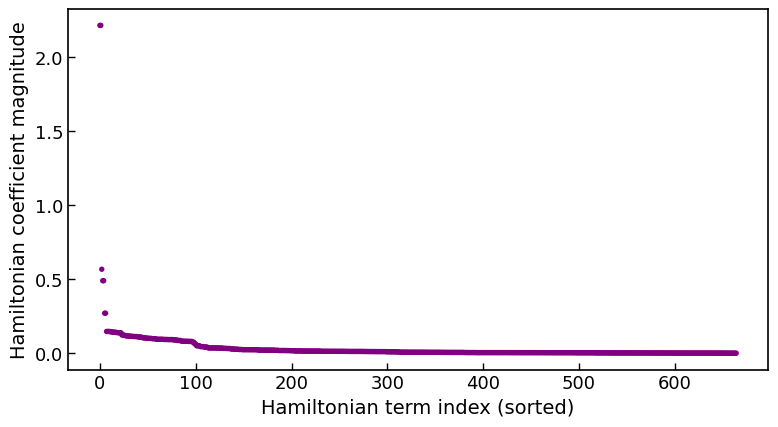

Plot saved to: generated_data/sorted_weights_scatter_gaussian.png


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Example: assuming w is already defined (replace this line with your actual data)
# w = np.random.randn(500)  # Example placeholder

# ---------------------------
# Compute & sort magnitudes
# ---------------------------
magnitudes = np.abs(w).copy()
print("Max magnitude:", np.max(magnitudes))

sorted_magnitudes = np.sort(magnitudes)[::-1]

# ---------------------------
# Save path (same directory)
# ---------------------------
savepath = "generated_data/"
os.makedirs(savepath, exist_ok=True)
filename = os.path.join(savepath, "sorted_weights_scatter_gaussian.png")

# ---------------------------
# Plot
# ---------------------------
plt.rcParams.update({
    "font.size": 14,
    "axes.labelsize": 16,
    "xtick.labelsize": 13,
    "ytick.labelsize": 13,
    "axes.linewidth": 1.2,
})

fig, ax = plt.subplots(figsize=(8, 4.5))

# Scatter plot (purple dots)
ax.scatter(range(len(sorted_magnitudes)), sorted_magnitudes,
           color='purple', s=15, edgecolors='none')

#ax.set_yscale('log')

# Labels & style
ax.set_xlabel('Hamiltonian term index (sorted)', fontsize=14)
ax.set_ylabel('Hamiltonian coefficient magnitude', fontsize=14)
ax.tick_params(axis='both', which='both', direction='in', length=5, width=1)
ax.grid(False)  # cleaner look

plt.tight_layout()

# ---------------------------
# Save and show
# ---------------------------
plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.show()

print(f"Plot saved to: {filename}")


Defining state sampler

In [7]:
"""n = 2 # num_qubits[molecule_name]
state_rand = np.random.rand(2**num_qubits[molecule_name],) + 1j*np.random.rand(2**num_qubits[molecule_name],)
state_rand = 1/np.linalg.norm(state_rand) * state_rand
print(state_rand)
state_sampler = StateSampler(state_rand)"""

'n = 2 # num_qubits[molecule_name]\nstate_rand = np.random.rand(2**num_qubits[molecule_name],) + 1j*np.random.rand(2**num_qubits[molecule_name],)\nstate_rand = 1/np.linalg.norm(state_rand) * state_rand\nprint(state_rand)\nstate_sampler = StateSampler(state_rand)'

In [8]:
state_sampler = StateSampler(state)
print(state)

[ 3.23167647e-17-9.22283974e-17j -1.91349703e-16+1.47374365e-18j
  2.24021989e-17-3.18169539e-18j ...  1.21700632e-18+1.02067460e-18j
 -6.65454606e-18+2.22125772e-18j  1.32820370e-17-1.24405163e-17j]


Initializing 'method' that will generate measurement scheme to estimate the energy

In [9]:
Nreps = 100
eps = 0.1
alpha = np.max(np.abs(w))/np.min(np.abs(w)) + np.min(np.abs(w))
#alpha = 1
#method = Shadow_Grouping(observables,w,eps,Bernstein_bound(alpha=alpha)())
method = Priori(observables,w,eps,Bernstein_bound(alpha=alpha)()) #based on gaurantee, epsilon v1, shadowgrouping till Nhits != 0, select only cliques which lead to complete setting
#method = Posteriori(observables,w,eps,Bernstein_bound(alpha=alpha)()) #based on gaurantee, epsilon v1, shadowgrouping till Nhits != 0, select only cliques which lead to complete setting
#method = Shadow_Grouping_Update77(observables,w,eps,Bernstein_bound(alpha=alpha)()) #based on gaurantee, epsilon v1, shadowgrouping till Nhits != 0, select only cliques which lead to complete setting
estimator = Energy_estimator(method,state_sampler,offset=offset,N_reps_exp=Nreps)
estimator.reset()
print("value of alpha is",alpha)

KeyboardInterrupt: 

Adding measurement scheme to estimator

In [ ]:
# Generating from scratch
Nrounds = 1000
t_1 = time.time()
estimator.reset()
num_points = 1
rmse_values = []
rmse_stds = []
#estimator.propose_next_settings(Nrounds)
for i in range(num_points):
    estimator.propose_next_settings(Nrounds//1)
    """estimator.clear_outcomes()
    n = 2 # num_qubits[molecule_name]
    state_rand = np.random.rand(2**num_qubits[molecule_name],) + 1j*np.random.rand(2**num_qubits[molecule_name],)
    state_rand = 1/np.linalg.norm(state_rand) * state_rand
    print(state_rand)
    estimator.state = StateSampler(state_rand)"""
    estimator.measure_and_get_running_avgs()
    energy_estimates = estimator.get_energy()
    """temp = abs(np.array(energy_estimates) - E_GS)**2
    MSE_value = np.mean(temp)
    MSE_std = np.std(temp) 
    RMSE_value = np.sqrt(MSE_value)
    RMSE_std = np.sqrt(MSE_std)
    rmse_values.append(RMSE_value)
    rmse_stds.append(RMSE_std)
    print(f"Shots: {i} | RMSE: {RMSE_value:.6f} | Std: {RMSE_std:.6f}")"""
    rmse, rmse_se, (ci_lo, ci_hi), boot_vals = bootstrap_rmse(
    energy_estimates, E_GS, n_boot=20000, ci=0.67)
    rmse_values.append(rmse)
    rmse_stds.append(rmse_se)
    print(f"Shots: {i} | RMSE: {rmse:.6f} | Std: {rmse_se:.6f}")

t_2 = time.time()
#print(estimator.measurement_scheme.settings_dict) 22222222
print(estimator.settings_dict)
print("Elapsed time in seconds: ", t_2 - t_1)
print("RMSE values", rmse_values)
print("RMSE STD", rmse_stds)
#print("average RMSE", np.mean(rmse_values))
#print("average STD", np.mean(rmse_stds))

length of cliques with epsilon is 974
number of incomplete settings 0
Shadow clique was selected 1 times
round number 1
epsilon_Bernstein_no_restricted_validity: inf
epsilon_Bernstein_no_restricted_validity_v2: (210.28611527510702, 5.180128866646182)
length of cliques with epsilon is 974
number of incomplete settings 0
epsilon for best clique is (21617.64599796713, array([2, 2, 3, 3, 3, 2, 2, 3, 2, 2, 3, 3, 3, 2]))
Shadow clique was selected 1 times
round number 2
epsilon_Bernstein_no_restricted_validity: inf
epsilon_Bernstein_no_restricted_validity_v2: (189.520120711885, 4.801976536829486)
length of cliques with epsilon is 975
number of incomplete settings 0
epsilon for best clique is (21265.83832523032, array([3, 3, 2, 3, 3, 3, 2, 1, 1, 3, 3, 3, 1, 3]))
Shadow clique was selected 1 times
round number 3
epsilon_Bernstein_no_restricted_validity: inf
epsilon_Bernstein_no_restricted_validity_v2: (162.66147759706314, 4.429985477932821)
length of cliques with epsilon is 976
number of incom

In [ ]:
import os
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np

# ------------------ Paths ------------------
save_dir = os.path.join(savepath, "epsilon_plots")
os.makedirs(save_dir, exist_ok=True)

log_path = os.path.join(
    save_dir,
    savename.format("all_methods").replace(".txt", "") + "_log.txt"
)

# ------------------ Save current method results ------------------
clean_method = str(method).split('.')[-1].split(' ')[0].replace('<', '').replace('>', '')

with open(log_path, "a", encoding="utf-8") as f:
    f.write(f"# METHOD: {clean_method}\n")
    f.write(f"# Nshots: {Nrounds}\n")
    for r, v in zip(estimator.measurement_scheme.rounds,
                    estimator.measurement_scheme.eps_values_v3):
        f.write(f"{r}\t{v}\n")
    f.write("\n")

print(f"Appended results for method '{clean_method}' to {log_path}")

# ------------------ Keep only newest block per method ------------------
def keep_latest_per_method_inplace(log_path: str) -> None:
    """Rewrite log so only the latest block per method remains."""
    if not os.path.exists(log_path):
        return

    with open(log_path, "r", encoding="utf-8") as f:
        lines = f.readlines()

    blocks = []  # (method, start_idx, end_idx)
    current_method, start_idx = None, None

    def close_block(end_idx):
        nonlocal current_method, start_idx
        if current_method is not None and start_idx is not None:
            blocks.append((current_method, start_idx, end_idx))
        current_method, start_idx = None, None

    for i, raw in enumerate(lines):
        line = raw.strip()
        if line.startswith("# METHOD:"):
            close_block(i)
            current_method = raw.split(":", 1)[1].strip()
            start_idx = i
        elif line == "" and current_method is not None:
            close_block(i + 1)
    close_block(len(lines))

    if not blocks:
        return

    # keep only latest occurrence for each method
    last_idx = {}
    for idx, (m, _, _) in enumerate(blocks):
        last_idx[m] = idx

    kept_blocks = [blocks[i][1:] for i in sorted(last_idx.values(), key=lambda x: blocks[x][1])]
    new_lines = []
    for s, e in kept_blocks:
        if new_lines and new_lines[-1].strip() != "":
            new_lines.append("\n")
        new_lines.extend(lines[s:e])
    if new_lines and not new_lines[-1].endswith("\n"):
        new_lines[-1] += "\n"

    with open(log_path, "w", encoding="utf-8") as f:
        f.writelines(new_lines)

keep_latest_per_method_inplace(log_path)

In [ ]:
# ------------------ Read all results from file ------------------
data = defaultdict(lambda: {"rounds": [], "vals": []})
current_method = None

with open(log_path, "r", encoding="utf-8") as f:
    for line in f:
        line = line.strip()
        if not line:
            continue
        if line.startswith("# METHOD:"):
            current_method = line.split(":", 1)[1].strip()
        elif line.startswith("#"):
            continue
        elif current_method is not None:
            try:
                r_str, v_str = line.split()
                data[current_method]["rounds"].append(float(r_str))
                data[current_method]["vals"].append(float(v_str))
            except ValueError:
                continue

# ------------------ Plot all methods ------------------
"""plt.figure("Epsilon evolution", clear=True)
for m, series in data.items():
    if series["rounds"]:
        plt.plot(series["rounds"], series["vals"], label=m)

plt.xlabel("Round")
plt.ylabel(r"$\epsilon$")
plt.title("Epsilon evolution over rounds")
plt.legend()
plt.grid(True)

#plt.xlim(200, max(series["rounds"]))
plt.yscale('log')
#plt.xscale('log')

combined_plot = os.path.join(
    save_dir,
    savename.format("combined_from_log").replace(".txt", "") + f"Nshots={Nrounds}.png"
)
plt.savefig(combined_plot, dpi=150, bbox_inches="tight")
print(f"Combined epsilon plot saved to {combined_plot}")

plt.show()"""


# ------------------ Plot all methods ------------------
plt.figure("Epsilon evolution", clear=True)
for m, series in data.items():
    if series["rounds"]:
        x = series["rounds"]
        y = series["vals"]

        # ✅ keep only points where x > 200
        x_filtered = [xv for xv, yv in zip(x, y) if xv > 0]
        y_filtered = [yv for xv, yv in zip(x, y) if xv > 0]

        # Only plot if something remains
        if x_filtered:
            plt.plot(x_filtered, y_filtered, label=m)

plt.xlabel("Round")
#plt.ylabel(r"$\epsilon$")
plt.ylabel("Upper Bound on Energy Deviation")
#plt.title("Epsilon evolution over rounds")
#plt.legend()
plt.grid(True)
plt.yscale('log')  # if you're using log scale

combined_plot = os.path.join(
    save_dir,
    savename.format("combined_from_log").replace(".txt", "") + f"Nshots={Nrounds}.png"
)
plt.savefig(combined_plot, dpi=150, bbox_inches="tight")
print(f"Combined epsilon plot saved to {combined_plot}")


plt.show()



In [ ]:
import matplotlib.pyplot as plt
import os

# ------------------ Plot all methods ------------------
plt.figure("Epsilon evolution", clear=True)

# Set global style parameters
plt.rcParams.update({
    "font.size": 14,
    "axes.labelsize": 14,
    "axes.titlesize": 14,
    "legend.fontsize": 14,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "lines.linewidth": 3
})

# ------------------ Fixed color order ------------------
colors = [
    "#2ca02c",  # green
    "#ff7f0e",  # orange
    "#1f77b4",  # blue
    "#d62728",  # red
    "#9467bd",  # purple
    "#8c564b",  # brown
    "#e377c2",  # pink
    "#7f7f7f",  # gray
    "#bcbd22",  # olive
    "#17becf"   # cyan
]
color_cycle = iter(colors)

# Different line styles
line_styles = ['-.', '--', ':', '-' , 'dotted']
style_cycle = iter(line_styles)

# ------------------ Plot each method ------------------
for m, series in data.items():
    if series["rounds"]:
        x = series["rounds"]
        y = series["vals"]

        # Filter x > 0
        x_filtered = [xv for xv, yv in zip(x, y) if xv > 0]
        y_filtered = [yv for xv, yv in zip(x, y) if xv > 0]

        if x_filtered:
            label = "ShadowGrouping" if m == "Shadow_Grouping" else m
            plt.plot(
                x_filtered,
                y_filtered,
                linestyle=next(style_cycle),
                color=next(color_cycle),   # ← fixed ordered colors
                label=label
            )

# Axes and formatting
plt.xlabel("Number of Measurement Rounds")
plt.ylabel("Upper Bound on Energy Deviation")
plt.legend(frameon=False)
plt.grid(False)
plt.yscale('log')

# Save plot
combined_plot = os.path.join(
    save_dir,
    savename.format("combined_from_log").replace(".txt", "") + f"Nshots={Nrounds}.png"
)
plt.savefig(combined_plot, dpi=300, bbox_inches="tight")
print(f"Combined epsilon plot saved to {combined_plot}")

plt.show()


In [ ]:
rmse, rmse_se, (ci_lo, ci_hi), boot_vals = bootstrap_rmse(
    energy_estimates, E_GS, n_boot=20000, ci=0.67)
print(f"RMSE = {rmse:.6g} ± {rmse_se:.6g} (bootstrap SE)")
print(f"67% percentile CI for RMSE: [{ci_lo:.6g}, {ci_hi:.6g}]")

In [ ]:
import os
import itertools
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# ------------------ Style ------------------
plt.rcParams.update({
    "font.size": 14,
    "axes.labelsize": 14,
    "axes.titlesize": 14,
    "legend.fontsize": 13,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "lines.linewidth": 3
})

# ------------------ Ordered Color Palette (Editable) ------------------
colors = [
    "#ff7f0e",  # orange
    "#1f77b4",  # blue
    "#2ca02c",  # green
    "#9467bd",  # purple
    "#17becf",  # cyan
    "#d62728",  # red
]

# ------------------ Patterns ------------------
style_cycle = itertools.cycle(['--', ':', '-.', ':'])
color_cycle = itertools.cycle(colors)

method_style = {}  # method → (color, linestyle)

def pretty_label(name: str) -> str:
    if name == "Shadow_Grouping":
        return "ShadowGrouping"
    return name.replace("-", "")

# ------------------ Figure ------------------
fig, ax = plt.subplots(figsize=(9.5, 6.5), constrained_layout=True)

# Plot main curves
for m, series in data.items():
    if not series["rounds"]:
        continue

    x = series["rounds"]
    y = series["vals"]

    if m not in method_style:
        method_style[m] = (next(color_cycle), next(style_cycle))

    color, ls = method_style[m]
    ax.plot(x, y, color=color, linestyle=ls, label=pretty_label(m))

ax.set_xlabel("Number of Measurement Rounds")
ax.set_ylabel("Upper Bound on Energy Deviation")
ax.set_yscale('log')
ax.grid(False)
ax.legend(frameon=False)

# Global x range
all_x = [xx for s in data.values() for xx in s["rounds"]]
x_min, x_max = min(all_x), max(all_x)

# ------------------ INSET 1 (Zoom < 200) ------------------
inset1 = ax.inset_axes([0.10, 0.55, 0.38, 0.38])  # left-top
for m, series in data.items():
    x = series["rounds"]
    y = series["vals"]
    xf = [xx for xx in x if xx < 200]
    yf = [yy for xx, yy in zip(x, y) if xx < 200]
    if xf:
        color, ls = method_style[m]
        inset1.plot(xf, yf, color=color, linestyle=ls)

inset1.set_xlim(x_min, min(200, x_max))
inset1.set_yscale("log")
inset1.grid(False)
inset1.tick_params(labelsize=9)
for spine in inset1.spines.values():
    spine.set_linewidth(1.1)
inset1.set_yticks([])
inset1.set_ylabel("")
inset1.tick_params(axis='y', which='both', length=0, labelleft=False)
# ------------------ INSET 2 (Zoom > 900) ------------------
if x_max > 900:
    inset2 = ax.inset_axes([0.58, 0.10, 0.38, 0.38])  # right-bottom
    for m, series in data.items():
        x = series["rounds"]
        y = series["vals"]
        xf = [xx for xx in x if xx > 900]
        yf = [yy for xx, yy in zip(x, y) if xx > 900]
        if xf:
            color, ls = method_style[m]
            inset2.plot(xf, yf, color=color, linestyle=ls)

    inset2.set_xlim(900, x_max)
    inset2.set_yscale("log")
    inset2.grid(False)
    inset2.tick_params(labelsize=9)
    for spine in inset2.spines.values():
        spine.set_linewidth(1.1)
    inset2.set_yticks([])
    inset2.set_ylabel("")
    inset2.tick_params(axis='y', which='both', length=0, labelleft=False)
# ------------------ Save & Show ------------------
combined_plot = os.path.join(
    save_dir,
    savename.replace(".txt", "").format("combined_from_log") + f"Nshots={Nrounds}.png"
)

fig.savefig(combined_plot, dpi=300)  # no bbox_inches="tight" → no renderer bugs
print(f"Saved: {combined_plot}")

plt.show()
plt.close(fig)


In [ ]:
pppp

In [ ]:
import os
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np

# ------------------ Paths ------------------
save_dir = os.path.join(savepath, "gaurantee_plots")
os.makedirs(save_dir, exist_ok=True)

log_path = os.path.join(
    save_dir,
    savename.format("all_methods").replace(".txt", "") + "_log.txt"
)

# ------------------ Save current method results ------------------
clean_method = str(method).split('.')[-1].split(' ')[0].replace('<', '').replace('>', '')

with open(log_path, "a", encoding="utf-8") as f:
    f.write(f"# METHOD: {clean_method}\n")
    f.write(f"# Nshots: {Nrounds}\n")
    for r, v in zip(estimator.measurement_scheme.rounds,
                    estimator.measurement_scheme.provablegaurantee):
        f.write(f"{r}\t{v}\n")
    f.write("\n")

print(f"Appended results for method '{clean_method}' to {log_path}")

# ------------------ Keep only newest block per method (in place) ------------------
def keep_latest_per_method_inplace(path: str) -> None:
    """
    Rewrite `path` so only the latest block per method remains.
    Block format:
      # METHOD: <name>
      # Nshots: <...>
      <round>\t<value>
      ...
      <blank line> (optional at EOF)
    """
    if not os.path.exists(path):
        return

    with open(path, "r", encoding="utf-8") as f:
        lines = f.readlines()

    blocks = []  # (method, start_idx, end_idx)
    current_method, start_idx = None, None

    def close_block(end_idx: int):
        nonlocal current_method, start_idx
        if current_method is not None and start_idx is not None:
            blocks.append((current_method, start_idx, end_idx))
        current_method, start_idx = None, None

    for i, raw in enumerate(lines):
        s = raw.strip()
        if s.startswith("# METHOD:"):
            close_block(i)
            current_method = raw.split(":", 1)[1].strip()
            start_idx = i
        elif s == "" and current_method is not None:
            close_block(i + 1)
    close_block(len(lines))  # flush last block if file ended without blank line

    if not blocks:
        return

    # keep only the last occurrence for each method
    last_idx_for_method = {}
    for idx, (m, _, _) in enumerate(blocks):
        last_idx_for_method[m] = idx  # overwrite => last wins

    keep_indices = sorted(last_idx_for_method.values(), key=lambda i: blocks[i][1])
    kept_spans = [(blocks[i][1], blocks[i][2]) for i in keep_indices]

    new_lines = []
    for s, e in kept_spans:
        if new_lines and new_lines[-1].strip() != "":
            new_lines.append("\n")
        new_lines.extend(lines[s:e])

    if new_lines and not new_lines[-1].endswith("\n"):
        new_lines[-1] += "\n"

    with open(path, "w", encoding="utf-8") as f:
        f.writelines(new_lines)

# Deduplicate log now
keep_latest_per_method_inplace(log_path)

# ------------------ Read all results from (deduped) file ------------------
data = defaultdict(lambda: {"rounds": [], "vals": []})
current_method = None

with open(log_path, "r", encoding="utf-8") as f:
    for line in f:
        line = line.strip()
        if not line:
            continue
        if line.startswith("# METHOD:"):
            current_method = line.split(":", 1)[1].strip()
        elif line.startswith("#"):
            continue
        elif current_method is not None:
            try:
                r_str, v_str = line.split()
                data[current_method]["rounds"].append(float(r_str))
                data[current_method]["vals"].append(float(v_str))
            except ValueError:
                continue

# ------------------ Plot all methods (latest run only) ------------------
plt.figure("Provable Guarantee evolution", clear=True)
for m, series in data.items():
    if series["rounds"]:
        x = np.asarray(series["rounds"], dtype=float)
        y = np.asarray(series["vals"], dtype=float)
        order = np.argsort(x)  # ensure clean monotone x
        plt.plot(x[order], y[order], label=m)  # no markers => no big dots

plt.xlabel("Round")
plt.ylabel("Guarantee")
plt.title("Provable Guarantee over rounds")
plt.legend()
plt.grid(True)

combined_plot = os.path.join(
    save_dir,
    savename.format("combined_from_log").replace(".txt", "") + f"Nshots={Nrounds}.png"
)
plt.savefig(combined_plot, dpi=150, bbox_inches="tight")
print(f"Combined plot saved to {combined_plot}")

plt.show()


In [ ]:
print('Total number of measurement rounds: ', estimator.num_settings)
#print('Total number of distinct measurement settings: ', len(estimator.measurement_scheme.settings_dict)) 22222222
print('Total number of distinct measurement settings: ', len(estimator.settings_dict))
N_samples = np.sum(np.array(estimator.measurement_scheme.N_hits))
print('Total number of samples across all observables: ', N_samples)
print('Total number of observables: ', len(observables))
print('Number of samples for each observable')
print(estimator.measurement_scheme.N_hits)
print('setting dictionary')
#print(estimator.measurement_scheme.settings_dict) 2222222222
print(estimator.settings_dict)

In [ ]:
import matplotlib.pyplot as plt
from os import mkdir
from os.path import isdir

# --- Global font size settings ---
plt.rcParams.update({
    "font.size": 16,
    "axes.labelsize": 16,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "legend.fontsize": 16,
})

# --- Filter settings with frequency >= 5 ---
filtered_settings = {k: v for k, v in estimator.settings_dict.items() if v >= 5}

# --- Sort by frequency (descending) ---
sorted_settings = dict(sorted(filtered_settings.items(), key=lambda item: item[1], reverse=True))

# Convert method to clean string for filename
clean_method = str(method).split('.')[-1].split(' ')[0].replace('<', '').replace('>', '')

# --- Plot ---
plt.figure(figsize=(14, 6))
plt.bar(sorted_settings.keys(), sorted_settings.values(), color='skyblue')

# Remove x-axis labels entirely
plt.xticks([], [])  # no tick positions, no tick labels
plt.xlabel("Distinct measurement settings", fontsize=16)  # keep label size consistent
plt.ylabel("Frequency of selection as the best setting", fontsize=16)

plt.yticks(fontsize=16)
plt.tight_layout()

# --- Save plot ---
if not isdir(savepath + "bargraph/"):
    mkdir(savepath + "bargraph/")

plot_filename = savepath + "bargraph/" + savename.format(clean_method).replace(".txt", "") + f"Nshots={Nrounds}.png"

plt.savefig(plot_filename, dpi=150, bbox_inches="tight")
print(f"Measurement settings frequency saved to {plot_filename}")

plt.show()


Computing the provable guarantees

In [ ]:
delta = 0.02

#settings_int, settings_reps = prepare_settings_for_numba(estimator.measurement_scheme.settings_dict) 22222222
settings_int, settings_reps = prepare_settings_for_numba(estimator.settings_dict)

# Scalar Hoeffding guarantees
epsilon_Hoeffding_scalar_original, _ = get_epsilon_Hoeffding_scalar_numba(delta, estimator.measurement_scheme.N_hits, estimator.measurement_scheme.w)
print('Hoeffding scalar original: ', epsilon_Hoeffding_scalar_original)
epsilon_Hoeffding_scalar_tighter, _ = get_epsilon_Hoeffding_scalar_tighter_numba(delta, estimator.measurement_scheme.N_hits, estimator.measurement_scheme.w, 
                                                                                 settings_int, settings_reps, estimator.measurement_scheme.obs)
print('Hoeffding scalar tighter: ', epsilon_Hoeffding_scalar_tighter)
# Scalar Chebyshev guarantees
epsilon_Chebyshev_scalar_original, _ = get_epsilon_Chebyshev_scalar_numba(delta, estimator.measurement_scheme.N_hits, estimator.measurement_scheme.w)
print('Chebyshev scalar original: ', epsilon_Chebyshev_scalar_original)
epsilon_Chebyshev_scalar_tighter, _ = get_epsilon_Chebyshev_scalar_tighter_numba(delta, estimator.measurement_scheme.N_hits, estimator.measurement_scheme.w, 
                                                                                 settings_int, settings_reps, estimator.measurement_scheme.obs)
print('Chebyshev scalar tighter: ', epsilon_Chebyshev_scalar_tighter)

Performing sampling over $N_{\textrm{reps}}$ experiments (as defined above), each with N rounds (set above when defining scheme): Joint version

In [ ]:
t_init = time.time()

estimator.clear_outcomes()
estimator.measure_and_get_running_avgs()
energy_estimates = estimator.get_energy()
"""temp = abs(np.array(energy_estimates) - E_GS)**2
MSE_value = np.mean(temp)
MSE_std = np.std(temp) 
RMSE_value = np.sqrt(MSE_value)
RMSE_std = np.sqrt(MSE_std)"""

rmse, rmse_se, (ci_lo, ci_hi), boot_vals = bootstrap_rmse(
    energy_estimates, E_GS, n_boot=20000, ci=0.67)

t_end = time.time()

print(f"RMSE: {rmse:.6f} \u00B1 {rmse_se:.6f}")
print("Elapsed time in seconds: ", t_end - t_init)

method_name = str(method).split('.')[-1].split(' ')[0].replace('<', '').replace('>', '')  # <-- Replace with the actual method name

results = {method_name: (rmse, rmse_se)}

In [ ]:
print(epsilon_Chebyshev_scalar_tighter/rmse)

In [ ]:
print(energy_estimates)

In [ ]:
print(estimator.running_N)

In [ ]:
print(estimator.running_avgs)

In [ ]:
import os, time
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

# --- paths & labels ----------------------------------------------------------
tab_dir = os.path.join(savepath, "tab1")
os.makedirs(tab_dir, exist_ok=True)

bar_dir = os.path.join(savepath, "emprical")
os.makedirs(bar_dir, exist_ok=True)


# MATCH ORIGINAL NAMING STYLE:
# save_dict(savepath+"tab1/"+savename.format(mapping_name).replace(".txt","")+f"_Nshots={NUM_STEPS}.txt",results)
base_name = savename.format(clean_method).replace(".txt","") + f"Nshots={Nrounds}"
txt_path = os.path.join(tab_dir, base_name + ".txt")
plot_filename = os.path.join(bar_dir, base_name + ".png")
run_label = base_name  # used for grouping in plots

# --- ensure TXT exists with header ------------------------------------------
header = "run_label\tmethod\trmse\trmse_std\tt_end_epoch\tt_end_iso\tnum_steps"
new_file = not os.path.isfile(txt_path)
if new_file:
    with open(txt_path, "w") as f:
        f.write(header + "\n")

# --- append rows for current results ----------------------------------------
# Expect: results = { "MethodName": (RMSE_value, RMSE_std), ... }
now_iso = time.strftime("%Y-%m-%dT%H:%M:%S", time.localtime(t_end))
with open(txt_path, "a") as f:
    for method, (rmse, rmse_std) in results.items():
        line = f"{run_label}\t{method}\t{float(rmse)}\t{float(rmse_std)}\t{float(t_end)}\t{now_iso}\t{int(Nrounds)}"
        f.write(line + "\n")

print(f"Saved {len(results)} row(s) to {txt_path}")

# --- read back entries for current run_label --------------------------------
rows = []
with open(txt_path, "r") as f:
    next(f)  # skip header
    for line in f:
        parts = line.strip().split("\t")
        if parts[0] == run_label:
            rows.append({
                "run_label": parts[0],
                "method": parts[1],
                "rmse": float(parts[2]),
                "rmse_std": float(parts[3]),
                "t_end_epoch": float(parts[4]),
                "t_end_iso": parts[5],
                "num_steps": int(parts[6])
            })

# Keep the *latest* per method
latest_by_method = OrderedDict()
for row in rows:
    latest_by_method[row["method"]] = row

methods = list(latest_by_method.keys())
rmse_values = [latest_by_method[m]["rmse"] for m in methods]
std_values  = [latest_by_method[m]["rmse_std"] for m in methods]

# --- plot --------------------------------------------------------------------
plt.figure(figsize=(7.5, 4.5))
plt.bar(methods, rmse_values, yerr=std_values, capsize=5)
plt.xlabel("Methods")
plt.ylabel("RMSE")
plt.title(f"RMSE ± std for {run_label}")
plt.xticks(rotation=75, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()

plt.savefig(plot_filename, dpi=150, bbox_inches="tight")
print(f"Empirical benchmark: RMSE plot saved to {plot_filename}")



In [ ]:
import os, time
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

# Optional: set default font size to 16 globally
plt.rcParams.update({
    "font.size": 16,
    "axes.titlesize": 16,
    "axes.labelsize": 16,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "legend.fontsize": 16,
})

# ------------------------------------------------------------
# Paths & naming (read-only)
# ------------------------------------------------------------
tab_dir   = os.path.join(savepath, "RMSE")
bar_dir   = os.path.join(savepath, "emprical")
os.makedirs(bar_dir, exist_ok=True)

base_name  = savename.format(mapping_name).replace(".txt","") + f"Nshots={Nrounds}"
txt_path   = os.path.join(tab_dir, base_name + ".txt")
plot_path  = os.path.join(bar_dir, base_name + ".png")
run_label  = base_name

base_root    = savename.format(mapping_name).replace(".txt","")
vs_txt_path  = os.path.join(tab_dir, base_root + "_vs_Nshots.txt")
vs_plot_path = os.path.join(bar_dir, base_root + "_RMSE_vs_Nshots.png")

# ------------------------------------------------------------
# 1) Bar chart (READ ONLY, green–orange–blue colors)
# ------------------------------------------------------------
if not os.path.isfile(txt_path):
    raise FileNotFoundError(f"Per-run file not found: {txt_path}")

rows = []
with open(txt_path, "r") as f:
    next(f, None)
    for line in f:
        parts = line.strip().split("\t")
        if len(parts) != 7:
            continue
        if parts[0] == run_label:
            try:
                rows.append({
                    "method": parts[1],
                    "rmse": float(parts[2]),
                    "rmse_std": float(parts[3]),
                })
            except ValueError:
                continue

# Keep latest per method
latest_by_method = OrderedDict()
for row in rows:
    latest_by_method[row["method"]] = row

methods   = list(latest_by_method.keys())
rmse_vals = [latest_by_method[m]["rmse"] for m in methods]
rmse_stds = [latest_by_method[m]["rmse_std"] for m in methods]

# Fixed colors: green, orange, blue
bar_colors = ['#2ca02c', '#ff7f0e', '#1f77b4']
colors = [bar_colors[i % len(bar_colors)] for i in range(len(methods))]

plt.figure(figsize=(7.5, 4.5))
plt.bar(methods, rmse_vals, yerr=rmse_stds, capsize=5, color=colors)
plt.xlabel("Methods", fontsize=16)
plt.ylabel("RMSE", fontsize=16)
plt.xticks(rotation=75, ha="right", fontsize=16)
plt.yticks(fontsize=16)
plt.grid(False)  # No grid
plt.tight_layout()
plt.savefig(plot_path, dpi=150, bbox_inches="tight")
print(f"Empirical benchmark: RMSE bar plot saved to {plot_path}")

# ------------------------------------------------------------
# 2) RMSE vs Number of Rounds (NO connecting lines; ensure ticks)
# ------------------------------------------------------------
if not os.path.isfile(vs_txt_path):
    raise FileNotFoundError(f"Accumulated file not found: {vs_txt_path}")

series = {}
with open(vs_txt_path, "r") as f:
    next(f, None)
    for line in f:
        parts = line.strip().split("\t")
        if len(parts) != 7:
            continue
        run_root_i, method_i, nshots_i, rmse_i, std_i, _, _ = parts
        if run_root_i != base_root:
            continue
        try:
            nshots_i = int(nshots_i)
            rmse_i   = float(rmse_i)
            std_i    = float(std_i)
        except ValueError:
            continue
        series.setdefault(method_i, []).append(
            {"Nshots": nshots_i, "rmse": rmse_i, "rmse_std": std_i}
        )

# Deduplicate and sort
for m, pts in list(series.items()):
    by_n = {}
    for p in pts:
        by_n[p["Nshots"]] = p
    series[m] = sorted(by_n.values(), key=lambda d: d["Nshots"])

plt.figure(figsize=(8.0, 5.0))

for i, (method_i, pts) in enumerate(series.items()):
    if not pts:
        continue
    xs = [p["Nshots"] for p in pts]
    ys = [p["rmse"] for p in pts]
    es = [p["rmse_std"] for p in pts]

    color = bar_colors[i % len(bar_colors)]
    # Plot ONLY markers (no connecting lines)
    plt.errorbar(xs, ys, yerr=es, fmt='o', capsize=4, markersize=7,
                 label=method_i, color=color, linewidth=1.8)

plt.xlabel("Number of measurement rounds", fontsize=16)
plt.ylabel("RMSE [Ha]", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Log scales
plt.yscale("log")
plt.xscale("log")

# No grid
plt.grid(False)

# Ensure visible major & minor tick marks
plt.minorticks_on()
plt.tick_params(axis='both', which='both', direction='in', length=6, width=1)

plt.legend(title="Method", ncol=1, fontsize=16, title_fontsize=16)
plt.tight_layout()
plt.savefig(vs_plot_path, dpi=150, bbox_inches="tight")
print(f"Empirical benchmark: RMSE-vs-rounds plot saved to {vs_plot_path}")


In [ ]:
pppp

In [ ]:
import os, time
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

# ------------------------------------------------------------
# Paths & naming (kept as in your script)
# ------------------------------------------------------------
tab_dir = os.path.join(savepath, "RMSE")
os.makedirs(tab_dir, exist_ok=True)

bar_dir = os.path.join(savepath, "emprical")
os.makedirs(bar_dir, exist_ok=True)

base_name  = savename.format(mapping_name).replace(".txt","") + f"Nshots={Nrounds}"
txt_path   = os.path.join(tab_dir, base_name + ".txt")
plot_path  = os.path.join(bar_dir, base_name + ".png")
run_label  = base_name

base_root    = savename.format(mapping_name).replace(".txt","")
vs_txt_path  = os.path.join(tab_dir, base_root + "_vs_Nshots.txt")      # keeping existing file name for continuity
vs_plot_path = os.path.join(bar_dir, base_root + "_RMSE_vs_Nshots.png") # keeping existing file name for continuity

# ------------------------------------------------------------
# 1) Write per-run TXT (append-safe)
# ------------------------------------------------------------
header = "run_label\tmethod\trmse\trmse_std\tt_end_epoch\tt_end_iso\tnum_steps"
if not os.path.isfile(txt_path):
    with open(txt_path, "w") as f:
        f.write(header + "\n")

now_iso = time.strftime("%Y-%m-%dT%H:%M:%S", time.localtime(t_end))

with open(txt_path, "a") as f:
    for method, (rmse, rmse_std) in results.items():
        line = f"{run_label}\t{method}\t{float(rmse)}\t{float(rmse_std)}\t{float(t_end)}\t{now_iso}\t{int(Nrounds)}"
        f.write(line + "\n")

print(f"Saved {len(results)} row(s) to {txt_path}")

# ------------------------------------------------------------
# 2) Bar chart (per-run)
# ------------------------------------------------------------
rows = []
with open(txt_path, "r") as f:
    next(f, None)
    for line in f:
        parts = line.strip().split("\t")
        if len(parts) != 7:
            continue
        if parts[0] == run_label:
            try:
                rows.append({
                    "method": parts[1],
                    "rmse": float(parts[2]),
                    "rmse_std": float(parts[3]),
                })
            except ValueError:
                continue

latest_by_method = OrderedDict()
for row in rows:
    latest_by_method[row["method"]] = row

methods   = list(latest_by_method.keys())
rmse_vals = [latest_by_method[m]["rmse"] for m in methods]
rmse_stds = [latest_by_method[m]["rmse_std"] for m in methods]

plt.figure(figsize=(7.5, 4.5))
plt.bar(methods, rmse_vals, yerr=rmse_stds, capsize=5)
plt.xlabel("Methods", fontsize=14)
plt.ylabel("RMSE", fontsize=14)
plt.xticks(rotation=75, ha="right", fontsize=14)
plt.yticks(fontsize=14)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.savefig(plot_path, dpi=150, bbox_inches="tight")
print(f"Empirical benchmark: RMSE bar plot saved to {plot_path}")

# ------------------------------------------------------------
# 3) Accumulate across rounds for RMSE-vs-rounds plot
# ------------------------------------------------------------
vs_header = "run_root\tmethod\tNshots\trmse\trmse_std\tt_end_epoch\tt_end_iso"
if not os.path.isfile(vs_txt_path):
    with open(vs_txt_path, "w") as f:
        f.write(vs_header + "\n")

with open(vs_txt_path, "a") as f:
    for method, (rmse, rmse_std) in results.items():
        f.write(f"{base_root}\t{method}\t{int(Nrounds)}\t{float(rmse)}\t{float(rmse_std)}\t{float(t_end)}\t{now_iso}\n")

print(f"Appended {len(results)} row(s) to {vs_txt_path}")

# Build time series per method
series = {}
with open(vs_txt_path, "r") as f:
    next(f, None)
    for line in f:
        parts = line.strip().split("\t")
        if len(parts) != 7:
            continue
        run_root_i, method_i, nshots_i, rmse_i, std_i, _, _ = parts
        if run_root_i != base_root:
            continue
        try:
            nshots_i = int(nshots_i)
            rmse_i   = float(rmse_i)
            std_i    = float(std_i)
        except ValueError:
            continue
        series.setdefault(method_i, []).append(
            {"Nshots": nshots_i, "rmse": rmse_i, "rmse_std": std_i}
        )

# Deduplicate by (method, Nshots): keep latest and sort
for m, pts in list(series.items()):
    by_n = {}
    for p in pts:
        by_n[p["Nshots"]] = p
    series[m] = sorted(by_n.values(), key=lambda d: d["Nshots"])

# ------------------------------------------------------------
# 4) Plot RMSE vs Number of Rounds (points only, no connecting lines)
# ------------------------------------------------------------
plt.figure(figsize=(8.0, 5.0))

for method_i, pts in series.items():
    if not pts:
        continue
    xs = [p["Nshots"] for p in pts]
    ys = [p["rmse"] for p in pts]
    es = [p["rmse_std"] for p in pts]

    # Plot only markers (no connecting lines)
    plt.errorbar(xs, ys, yerr=es, fmt='o', linestyle='none', capsize=4,
                 label=method_i, markersize=6)

# Labels and ticks with font size 14
plt.xlabel("Number of measurement rounds", fontsize=14)
plt.ylabel("RMSE [Ha]", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# No title
# plt.title(f"RMSE vs Number of rounds for {base_root}")

# Log scales and grid
plt.yscale("log")
plt.xscale("log")
plt.grid(True, which="both", axis="both", linestyle="--", alpha=0.7)

# Legend with font size 14
plt.legend(title="Method", ncol=1, fontsize=14, title_fontsize=14)

plt.tight_layout()
plt.savefig(vs_plot_path, dpi=150, bbox_inches="tight")
print(f"Empirical benchmark: RMSE-vs-rounds plot saved to {vs_plot_path}")


In [ ]:
import os, time
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

# ------------------------------------------------------------
# Paths & naming (matches your original naming convention)
# ------------------------------------------------------------
tab_dir = os.path.join(savepath, "RMSE")
os.makedirs(tab_dir, exist_ok=True)

bar_dir = os.path.join(savepath, "emprical")  # keeping your folder name
os.makedirs(bar_dir, exist_ok=True)

# Example original pattern:
# save_dict(savepath+"tab1/"+savename.format(mapping_name).replace(".txt","")+f"_Nshots={NUM_STEPS}.txt", results)
base_name  = savename.format(mapping_name).replace(".txt","") + f"Nshots={Nrounds}"
txt_path   = os.path.join(tab_dir, base_name + ".txt")
plot_path  = os.path.join(bar_dir, base_name + ".png")
run_label  = base_name

# Root name without the Nshots suffix, e.g. "LiH_molecule_JW_empirical"
base_root       = savename.format(mapping_name).replace(".txt","")
vs_txt_path     = os.path.join(tab_dir, base_root + "_vs_Nshots.txt")
vs_plot_path    = os.path.join(bar_dir, base_root + "_RMSE_vs_Nshots.png")
powerfit_path   = os.path.join(tab_dir, base_root + "_powerfit.txt")  # stores A,c per method for N>1000

# ------------------------------------------------------------
# 1) Write per-run TXT (append-safe)
# ------------------------------------------------------------
header = "run_label\tmethod\trmse\trmse_std\tt_end_epoch\tt_end_iso\tnum_steps"
if not os.path.isfile(txt_path):
    with open(txt_path, "w") as f:
        f.write(header + "\n")

now_iso = time.strftime("%Y-%m-%dT%H:%M:%S", time.localtime(t_end))

with open(txt_path, "a") as f:
    for method, (rmse, rmse_std) in results.items():
        line = f"{run_label}\t{method}\t{float(rmse)}\t{float(rmse_std)}\t{float(t_end)}\t{now_iso}\t{int(Nrounds)}"
        f.write(line + "\n")

print(f"Saved {len(results)} row(s) to {txt_path}")

# ------------------------------------------------------------
# 2) Bar chart (per-run)
# ------------------------------------------------------------
# Read back only current run_label
rows = []
with open(txt_path, "r") as f:
    next(f, None)
    for line in f:
        parts = line.strip().split("\t")
        if len(parts) != 7:
            continue
        if parts[0] == run_label:
            try:
                rows.append({
                    "method": parts[1],
                    "rmse": float(parts[2]),
                    "rmse_std": float(parts[3]),
                })
            except ValueError:
                continue

# Keep latest per method
latest_by_method = OrderedDict()
for row in rows:
    latest_by_method[row["method"]] = row

methods     = list(latest_by_method.keys())
rmse_vals   = [latest_by_method[m]["rmse"] for m in methods]
rmse_stds   = [latest_by_method[m]["rmse_std"] for m in methods]

plt.figure(figsize=(7.5, 4.5))
plt.bar(methods, rmse_vals, yerr=rmse_stds, capsize=5)
plt.xlabel("Methods")
plt.ylabel("RMSE")
plt.title(f"RMSE ± std for {run_label}")
plt.xticks(rotation=75, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.savefig(plot_path, dpi=150, bbox_inches="tight")
print(f"Empirical benchmark: RMSE bar plot saved to {plot_path}")

# ------------------------------------------------------------
# 3) Accumulate across Nshots for RMSE-vs-Nshots plot
# ------------------------------------------------------------
# Ensure vs file exists with header
vs_header = "run_root\tmethod\tNshots\trmse\trmse_std\tt_end_epoch\tt_end_iso"
if not os.path.isfile(vs_txt_path):
    with open(vs_txt_path, "w") as f:
        f.write(vs_header + "\n")

# Append this run's results to the vs_Nshots file
with open(vs_txt_path, "a") as f:
    for method, (rmse, rmse_std) in results.items():
        f.write(f"{base_root}\t{method}\t{int(Nrounds)}\t{float(rmse)}\t{float(rmse_std)}\t{float(t_end)}\t{now_iso}\n")

print(f"Appended {len(results)} row(s) to {vs_txt_path}")

# Read back & build time series per method for this base_root
series = {}  # method -> list of points dicts: {"Nshots", "rmse", "rmse_std"}
with open(vs_txt_path, "r") as f:
    next(f, None)
    for line in f:
        parts = line.strip().split("\t")
        if len(parts) != 7:
            continue
        run_root_i, method_i, nshots_i, rmse_i, std_i, _, _ = parts
        if run_root_i != base_root:
            continue
        try:
            nshots_i = int(nshots_i)
            rmse_i   = float(rmse_i)
            std_i    = float(std_i)
        except ValueError:
            continue
        series.setdefault(method_i, []).append(
            {"Nshots": nshots_i, "rmse": rmse_i, "rmse_std": std_i}
        )

# Deduplicate by (method, Nshots): keep latest
for m, pts in list(series.items()):
    by_n = {}
    for p in pts:
        by_n[p["Nshots"]] = p
    series[m] = sorted(by_n.values(), key=lambda d: d["Nshots"])

# ------------------------------------------------------------
# 4) Plot RMSE vs Nshots
#    - Show error bars as points only (no global connecting lines)
#    - Connect points with a dotted line ONLY for Nshots > 1000
#    - Fit power law using only Nshots > 1000 and plot dotted fit
#    - Logarithmic y-axis
# ------------------------------------------------------------
# Prepare/clear powerfit file header
pf_header = "run_root\tmethod\tA\tc\tn_points_fit\tNmin_fit"
with open(powerfit_path, "w") as f:
    f.write(pf_header + "\n")

plt.figure(figsize=(8.0, 5.0))

for method_i, pts in series.items():
    if not pts:
        continue
    xs_all = [p["Nshots"] for p in pts]
    ys_all = [p["rmse"]   for p in pts]
    es_all = [p["rmse_std"] for p in pts]

    # Plot all points with error bars (no connecting line)
    plt.errorbar(xs_all, ys_all, yerr=es_all, fmt='o', capsize=4, linestyle='none', label=method_i)

    # Connect only points with Nshots > 1000 using a dotted line
    xs_gt = [x for x in xs_all if x > 999]
    ys_gt = [y for x, y in zip(xs_all, ys_all) if x > 999]
    if len(xs_gt) >= 2:
        # Sort by Nshots to connect in order
        order = np.argsort(xs_gt)
        xs_gt_sorted = np.array(xs_gt)[order]
        ys_gt_sorted = np.array(ys_gt)[order]
        plt.plot(xs_gt_sorted, ys_gt_sorted, linestyle=":", marker=None)  # dotted connection for >1000 only

    # ---- Power-law regression for Nshots > 1000: ε(N) = A / N^c ----
    if len(xs_gt) >= 2 and all(y > 0 for y in ys_gt):
        logX = np.log(xs_gt_sorted.astype(float))
        logY = np.log(ys_gt_sorted.astype(float))
        m, b = np.polyfit(logX, logY, 1)  # logY = m*logX + b  => A = e^b, c = -m
        A = float(np.exp(b))
        c = float(-m)

        # Save fit params
        with open(powerfit_path, "a") as pf:
            pf.write(f"{base_root}\t{method_i}\t{A:.8e}\t{c:.8f}\t{len(xs_gt_sorted)}\t1000\n")

        # Smooth fit curve over the >1000 range
        x_fit = np.linspace(xs_gt_sorted.min(), xs_gt_sorted.max(), 200)
        y_fit = A / (x_fit ** c)

        # Plot the fit as a dotted line (overlay)
        plt.plot(x_fit, y_fit, linestyle=":", label=f"{method_i} fit (c={c:.2f})")

plt.xlabel("Number of shots (Nshots)")
plt.ylabel("RMSE")
plt.title(f"RMSE vs Nshots for {base_root}")
plt.yscale("log")
plt.xscale("log")# logarithmic vertical axis
plt.grid(True, which="both", axis="both", linestyle="--", alpha=0.7)
plt.legend(title="Method", ncol=1)
plt.tight_layout()
plt.savefig(vs_plot_path, dpi=150, bbox_inches="tight")
print(f"Empirical benchmark: RMSE-vs-Nshots plot saved to {vs_plot_path}")
print(f"Power-law fit parameters written to {powerfit_path}")


In [ ]:
# --- NEW CELL: Bar chart of c with std/uncertainty per method ---

import os
import numpy as np
import matplotlib.pyplot as plt

# Reuse your existing paths/vars:
# - base_root, vs_txt_path, bar_dir should already exist in your session.
# If not, set them accordingly before running this cell.

# 1) Read series back (same as earlier, but lightweight)
series = {}
with open(vs_txt_path, "r") as f:
    next(f, None)
    for line in f:
        parts = line.strip().split("\t")
        if len(parts) != 7:
            continue
        run_root_i, method_i, nshots_i, rmse_i, std_i, _, _ = parts
        if run_root_i != base_root:
            continue
        try:
            nshots_i = int(nshots_i)
            rmse_i   = float(rmse_i)
        except ValueError:
            continue
        series.setdefault(method_i, []).append({"Nshots": nshots_i, "rmse": rmse_i})

# Deduplicate by Nshots and sort
for m, pts in list(series.items()):
    by_n = {}
    for p in pts:
        by_n[p["Nshots"]] = p
    series[m] = sorted(by_n.values(), key=lambda d: d["Nshots"])

# 2) For each method, fit log–log line for Nshots>1000 and compute slope SE
def fit_c_with_se(xs, ys):
    """
    Given arrays xs (Nshots) and ys (rmse), both > 0 and len>=2,
    returns (c, se_c) where c = -slope(logY vs logX),
    and se_c is the standard error of the slope (uncertainty of c).
    """
    X = np.log(np.asarray(xs, dtype=float))
    Y = np.log(np.asarray(ys, dtype=float))
    n = X.size
    if n < 2 or np.any(~np.isfinite(X)) or np.any(~np.isfinite(Y)):
        return np.nan, np.nan

    # Linear regression Y = m X + b
    m, b = np.polyfit(X, Y, 1)

    # Standard error of slope m:
    # se_m = sqrt( RSS / (n-2) / Sxx ), where RSS = sum(resid^2), Sxx = sum((X - Xbar)^2)
    if n >= 3:
        Yhat = m * X + b
        resid = Y - Yhat
        RSS = float(np.sum(resid**2))
        Sxx = float(np.sum((X - X.mean())**2))
        if Sxx > 0:
            sigma2 = RSS / (n - 2)
            se_m = np.sqrt(sigma2 / Sxx)
        else:
            se_m = np.nan
    else:
        # With only 2 points, no DOF for variance estimate; no SE available
        se_m = np.nan

    c = -m
    se_c = se_m  # c = -m => same standard error
    return float(c), float(se_c) if np.isfinite(se_m) else np.nan

methods = []
c_vals  = []
c_errs  = []

NMIN = 1000  # threshold for "asymptotic" fit region

for method, pts in series.items():
    xs_gt = [p["Nshots"] for p in pts if p["Nshots"] > NMIN and p["rmse"] > 0]
    ys_gt = [p["rmse"]   for p in pts if p["Nshots"] > NMIN and p["rmse"] > 0]
    if len(xs_gt) >= 2:
        c, se_c = fit_c_with_se(xs_gt, ys_gt)
        methods.append(method)
        c_vals.append(c)
        c_errs.append(se_c)
    else:
        # Not enough points to fit; include as NaN so you see it missing
        methods.append(method)
        c_vals.append(np.nan)
        c_errs.append(np.nan)

# 3) Plot a single bar chart with error bars (one bar per method)
plt.figure(figsize=(7.5, 4.5))
bars = plt.bar(methods, c_vals, yerr=c_errs, capsize=6)
plt.ylabel("Exponent c (± SE)")
plt.title(f"Power-law exponent c with uncertainty (> {NMIN} shots)\n{base_root}")
plt.xticks(rotation=60, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()

# Save alongside your other empirical plots
c_plot_path = os.path.join(bar_dir, base_root + "_c_bar.png")
plt.savefig(c_plot_path, dpi=150, bbox_inches="tight")
print(f"Saved c bar chart with error bars to {c_plot_path}")

# --- Optional: if you truly want a separate (single-bar) plot per method, uncomment below ---
for method, c, err in zip(methods, c_vals, c_errs):
    plt.figure(figsize=(4.0, 3.2))
    plt.bar([method], [c], yerr=[err], capsize=6)
    plt.ylabel("Exponent c (± SE)")
    plt.title(f"c for {method} (> {NMIN} shots)")
    plt.xticks(rotation=0)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    out_path = os.path.join(bar_dir, f"{base_root}_c_{method}.png")
    plt.savefig(out_path, dpi=150, bbox_inches="tight")
    print(f"Saved: {out_path}")


In [ ]:
# --- COMPLETE CELL: N required for chemical accuracy + log-scale bar chart with log-consistent error bars ---

import os
import numpy as np
import matplotlib.pyplot as plt

# ===============================
# Config / Inputs already in env:
#   base_root, vs_txt_path, bar_dir
# If not defined, set them here.
# ===============================

# 0) Target accuracy (Hartree)
epsilon_mHa = 1.6              # chemical accuracy in mHa
epsilon     = epsilon_mHa * 1e-3  # convert to Hartree

# 1) Read data back (per method)
series = {}
with open(vs_txt_path, "r") as f:
    next(f, None)  # skip header
    for line in f:
        parts = line.strip().split("\t")
        if len(parts) != 7:
            continue
        run_root_i, method_i, nshots_i, rmse_i, std_i, _, _ = parts
        if run_root_i != base_root:
            continue
        try:
            nshots_i = int(nshots_i)
            rmse_i   = float(rmse_i)
        except ValueError:
            continue
        # Keep only positive RMSEs (log required)
        if rmse_i > 0:
            series.setdefault(method_i, []).append({"Nshots": nshots_i, "rmse": rmse_i})

# Deduplicate by Nshots and sort
for m, pts in list(series.items()):
    by_n = {}
    for p in pts:
        by_n[p["Nshots"]] = p
    series[m] = sorted(by_n.values(), key=lambda d: d["Nshots"])

# 2) Fit log–log line (N>1000)
#    log(rmse) = m * log(N) + b  =>  A = exp(b),  c = -m
def fit_loglog_with_se(xs, ys):
    X = np.log(np.asarray(xs, dtype=float))
    Y = np.log(np.asarray(ys, dtype=float))
    n = X.size
    if n < 2 or not np.all(np.isfinite(X)) or not np.all(np.isfinite(Y)):
        return np.nan, np.nan, np.nan, np.nan  # m, b, se_m, se_b

    m, b = np.polyfit(X, Y, 1)

    # OLS standard errors:
    # se_m = sqrt( RSS / (n-2) / Sxx )
    # se_b = sqrt( RSS / (n-2) * (1/n + Xbar^2 / Sxx) )
    if n >= 3:
        Yhat = m * X + b
        resid = Y - Yhat
        RSS = float(np.sum(resid**2))
        Sxx = float(np.sum((X - X.mean())**2))
        if Sxx > 0:
            sigma2 = RSS / max(n - 2, 1)
            se_m = np.sqrt(sigma2 / Sxx)
            se_b = np.sqrt(sigma2 * (1.0/n + (X.mean()**2) / Sxx))
        else:
            se_m = np.nan
            se_b = np.nan
    else:
        se_m = np.nan
        se_b = np.nan

    return float(m), float(b), float(se_m), float(se_b)

NMIN = 1000

methods, N_vals, N_errs = [], [], []

for method, pts in series.items():
    xs_gt = [p["Nshots"] for p in pts if p["Nshots"] > NMIN]
    ys_gt = [p["rmse"]   for p in pts if p["Nshots"] > NMIN]

    if len(xs_gt) >= 2 and all(y > 0 for y in ys_gt):
        m, b, se_m, se_b = fit_loglog_with_se(xs_gt, ys_gt)
        c = -m
        A = np.exp(b)

        # Uncertainties for A and c
        dA = A * se_b if np.isfinite(se_b) else np.nan
        dc = se_m      if np.isfinite(se_m) else np.nan

        valid = np.isfinite(A) and np.isfinite(c) and (A > 0) and (c != 0) and (epsilon > 0)
        if valid:
            N_req = (A / epsilon) ** (1.0 / c)
            if np.isfinite(N_req) and N_req > 0:
                # Linear error propagation: ΔN = N/c * ΔA/A + N*log(N) * Δc/c
                termA = (N_req / c) * (dA / A) if (np.isfinite(dA) and A > 0 and c != 0) else np.nan
                termc = N_req * np.log(N_req) * (dc / c) if (np.isfinite(dc) and c != 0) else np.nan
                dN = termA + termc
                # Fallback if only one term is defined
                if np.isnan(dN):
                    if np.isfinite(termA) and not np.isfinite(termc):
                        dN = termA
                    elif np.isfinite(termc) and not np.isfinite(termA):
                        dN = termc

                # Ensure non-negative uncertainty
                if np.isfinite(dN) and dN < 0:
                    dN = abs(dN)

                methods.append(method)
                N_vals.append(float(N_req))
                N_errs.append(float(dN) if np.isfinite(dN) else np.nan)
                continue

    # If not enough data / invalid fit, log as NaN so it's visible in the table
    methods.append(method)
    N_vals.append(np.nan)
    N_errs.append(np.nan)

# 3) Plot bar chart with log y-axis and log-consistent asymmetric error bars
# Convert linear ΔN to log-space symmetric error, then back to asymmetric linear yerr
lower_errs, upper_errs = [], []
for val, err in zip(N_vals, N_errs):
    if np.isfinite(val) and np.isfinite(err) and val > 0 and err > 0:
        dlog = err / val                    # Δln N ≈ ΔN / N
        lower = val - val * np.exp(-dlog)   # N - N*e^{-ΔlnN}
        upper = val * np.exp(dlog) - val    # N*e^{ΔlnN} - N
        # guard for tiny/negative numerical noise
        lower_errs.append(max(lower, 0.0))
        upper_errs.append(max(upper, 0.0))
    else:
        lower_errs.append(np.nan)
        upper_errs.append(np.nan)

yerr_asym = np.array([lower_errs, upper_errs])

plt.figure(figsize=(9, 5))
plt.bar(methods, N_vals, yerr=yerr_asym, capsize=6)
plt.ylabel("Shots N for chemical accuracy")
plt.title(f"N to reach ε = {epsilon_mHa} mHa (base: {base_root})")
plt.xticks(rotation=60, ha="right")
plt.yscale("log")  # logarithmic y-axis
plt.grid(axis="y", linestyle="--", alpha=0.7, which="both")
plt.tight_layout()

out_path = os.path.join(bar_dir, f"{base_root}_N_for_chem_accuracy_log.png")
plt.savefig(out_path, dpi=150, bbox_inches="tight")
print(f"Saved bar chart of N (± ΔN) [log axis & log-consistent errors] to {out_path}")

# 4) Print a compact table
print("\nEstimated N for chemical accuracy:")
for mth, nval, nerr in zip(methods, N_vals, N_errs):
    if np.isfinite(nval):
        if np.isfinite(nerr):
            print(f"  {mth:20s} N ≈ {nval:.3e}  ± {nerr:.2e}")
        else:
            print(f"  {mth:20s} N ≈ {nval:.3e}  (uncertainty unavailable)")
    else:
        print(f"  {mth:20s} N: unavailable (insufficient data for fit)")


In [ ]:
import os
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np

# ------------------ Paths ------------------
save_dir = os.path.join(savepath, "bound_plots")
os.makedirs(save_dir, exist_ok=True)

log_path = os.path.join(
    save_dir,
    savename.format("all_methods").replace(".txt", "") + "_log.txt"
)

# ------------------ Save current method results ------------------
clean_method = str(method).split('.')[-1].split(' ')[0].replace('<', '').replace('>', '')

with open(log_path, "a", encoding="utf-8") as f:
    f.write(f"# METHOD: {clean_method}\n")
    f.write(f"# Nshots: {Nrounds}\n")
    for r, v in zip(estimator.measurement_scheme.rounds,
                    estimator.measurement_scheme.inconfidence):
        f.write(f"{r}\t{v}\n")
    f.write("\n")  # blank line to separate methods

print(f"Appended results for method '{clean_method}' to {log_path}")

# ------------------ Keep only newest block per method (in place) ------------------
def keep_latest_per_method_inplace(path: str) -> None:
    """
    Rewrite `path` so only the latest block per method remains.
    Block format:
      # METHOD: <name>
      # Nshots: <...>
      <round>\t<value>
      ...
      <blank line> (optional at EOF)
    """
    if not os.path.exists(path):
        return

    with open(path, "r", encoding="utf-8") as f:
        lines = f.readlines()

    blocks = []  # (method, start_idx, end_idx)
    current_method, start_idx = None, None

    def close_block(end_idx: int):
        nonlocal current_method, start_idx
        if current_method is not None and start_idx is not None:
            blocks.append((current_method, start_idx, end_idx))
        current_method, start_idx = None, None

    for i, raw in enumerate(lines):
        s = raw.strip()
        if s.startswith("# METHOD:"):
            close_block(i)
            current_method = raw.split(":", 1)[1].strip()
            start_idx = i
        elif s == "" and current_method is not None:
            close_block(i + 1)
    close_block(len(lines))  # flush last block if file ended without blank line

    if not blocks:
        return

    # Keep only the last occurrence for each method
    last_idx_for_method = {}
    for idx, (m, _, _) in enumerate(blocks):
        last_idx_for_method[m] = idx  # overwrite => last wins

    # Preserve file-order of last appearances
    keep_indices = sorted(last_idx_for_method.values(), key=lambda i: blocks[i][1])
    kept_spans = [(blocks[i][1], blocks[i][2]) for i in keep_indices]

    new_lines = []
    for s, e in kept_spans:
        if new_lines and new_lines[-1].strip() != "":
            new_lines.append("\n")
        new_lines.extend(lines[s:e])

    if new_lines and not new_lines[-1].endswith("\n"):
        new_lines[-1] += "\n"

    with open(path, "w", encoding="utf-8") as f:
        f.writelines(new_lines)

# Deduplicate log now
keep_latest_per_method_inplace(log_path)

# ------------------ Read all results from (deduped) file ------------------
data = defaultdict(lambda: {"rounds": [], "vals": []})
current_method = None

with open(log_path, "r", encoding="utf-8") as f:
    for line in f:
        line = line.strip()
        if not line:
            continue
        if line.startswith("# METHOD:"):
            current_method = line.split(":", 1)[1].strip()
        elif line.startswith("#"):
            continue  # skip comments/metadata
        elif current_method is not None:
            try:
                r_str, v_str = line.split()
                data[current_method]["rounds"].append(float(r_str))
                data[current_method]["vals"].append(float(v_str))
            except ValueError:
                continue

# ------------------ Plot all methods (latest run only, no markers) ------------------
plt.figure("Inconfidence Bound evolution", clear=True)
for m, series in data.items():
    if series["rounds"]:
        x = np.asarray(series["rounds"], dtype=float)
        y = np.asarray(series["vals"], dtype=float)
        order = np.argsort(x)  # ensure clean monotone x
        plt.plot(x[order], y[order], label=m)  # lines only

plt.xlabel("Round")
plt.ylabel("Inconfidence Bound")
plt.title("Inconfidence Bound over rounds (latest run per method)")
plt.legend()
plt.grid(True)

combined_plot = os.path.join(
    save_dir,
    savename.format("combined_from_log").replace(".txt", "") + f"Nshots={Nrounds}.png"
)
plt.savefig(combined_plot, dpi=150, bbox_inches="tight")
print(f"Combined plot saved to {combined_plot}")

plt.show()


# u